# Calculate regional quantities of the momentum fluxes

This analysis supports Figures 3-8 and the Tables in the paper.

Author: Brian Green (briangre@stanford.edu)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
from dataclasses import dataclass
import warnings
from scipy.ndimage import label
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.signal
import datetime
from mpl_toolkits.basemap import Basemap

from tqdm.notebook import tqdm
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

warnings.simplefilter("ignore")
    
# Replace Basemap with Cartopy (Basemap messes up Antarctica):
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

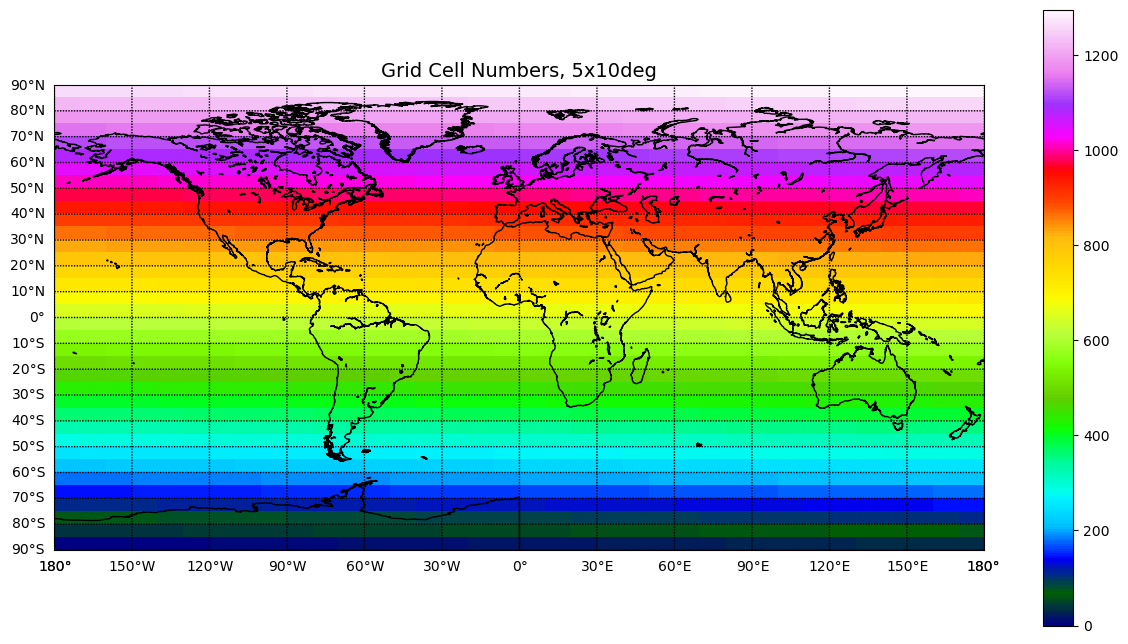

In [2]:
# Load in the data and assign a "grid cell number" to each time step

dtypes = {'flight_id': str,
          'time': str,
          'latitude': np.float64,
          'longitude': np.float64,
          'altitude': np.float64,
          'pressure': np.float64,
          'wind_u': np.float64,
          'wind_v': np.float64,
          'T_cosmic': np.float64,
          'dTdz_cosmic': np.float64,
          'N_cosmic': np.float64,
          'segment_id': np.int64,
          'u_smooth': np.float64,
          'v_smooth': np.float64,
          'flux_east': np.float64,
          'flux_west': np.float64,
          'flux_north': np.float64,
          'flux_south': np.float64,
          'flux_east_HF': np.float64,
          'flux_west_HF': np.float64,
          'flux_north_HF': np.float64,
          'flux_south_HF': np.float64,
          'flux_east_MF': np.float64,
          'flux_west_MF': np.float64,
          'flux_north_MF': np.float64,
          'flux_south_MF': np.float64,
          'flux_east_LF': np.float64,
          'flux_west_LF': np.float64,
          'flux_north_LF': np.float64,
          'flux_south_LF': np.float64}

flights = pd.read_csv('loon_GW_momentum_fluxes.csv', parse_dates=['time'], infer_datetime_format=True,
                      dtype=dtypes, usecols=dtypes.keys())
flights['month'] = flights.time.apply(lambda x: x.month)
flights['year'] = flights.time.apply(lambda x: x.year)

nlat_grid = 36 # 5deg, 90N to 90S
nlon_grid = 36 # 10deg, 180W to 180E 
lat_grid = 5*np.arange(nlat_grid) - 87.5
lon_grid = 10*np.arange(nlon_grid) - 175
min_n_obs = 1000

# Create a cell "number" for each grid cell, essentially making each cell its own region
grid_cell_numbers = np.arange(nlat_grid*nlon_grid).reshape(nlat_grid,nlon_grid)
grid_cell_numbers = grid_cell_numbers.astype(float)

# Make a list of each grid cell's latitude and longitude
[temp_lat, temp_lon] = np.meshgrid(lat_grid, lon_grid)
temp_lat = np.reshape(temp_lat, nlat_grid*nlon_grid)
temp_lon = np.reshape(temp_lon, nlat_grid*nlon_grid)

# Apply a cell number to each GW packet
data_lat = np.array(flights.latitude)
data_lon = np.array(flights.longitude)
temp = np.reshape(np.transpose(grid_cell_numbers), nlat_grid*nlon_grid)
f = interpolate.NearestNDInterpolator((temp_lat,temp_lon),temp)
# this is how 2D interpolation is done from a grid to a list of points:
data_cellnum = [float(f(*p)) for p in zip(data_lat, data_lon)]
data_cellnum = np.round(np.array(data_cellnum)) # round to the region's integer value
flights['grid_cell_number'] = data_cellnum

# Plot the cell numbers
fig = plt.figure(num=None, figsize=(15,8))
map1 = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,\
            resolution='l',projection='cyl')
map1.drawcoastlines()
map1.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
map1.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
data = grid_cell_numbers.copy()
map1.imshow(data, cmap='gist_ncar')
plt.title('Grid Cell Numbers, 5x10deg', fontsize=14);
plt.colorbar();

In [3]:
# Chop off the first and last two hours of each segment
def dt_start_end(segment):
    
    segment['dt_start'] = (segment.time - segment.time.iloc[0])/pd.Timedelta(1,'hours')
    segment['dt_end'] = (segment.time.iloc[-1] - segment.time)/pd.Timedelta(1,'hours')
    
    return segment

flights = flights.groupby('segment_id').progress_apply(dt_start_end)
flights = flights[flights.dt_start > 2]
flights = flights[flights.dt_end > 2]

  0%|          | 0/938 [00:00<?, ?it/s]

In [4]:
# Delete depressurizations

# My approach, based on running a few depressurizations through the wavelet analysis, is to delete
# both the depressurization and the data within 2 hours (to the nearsest hour, rounding up) or the 
# width of the depressurization, whichever is bigger, on either side of it.
flights['depressurization'] = 0

# Tropical Pacific
# Segment 284 (Flight I-195)
flights.loc[(flights.flight_id == 'I-195') & 
        (flights.time >= np.datetime64('2014-07-09 07:00:00')) &
        (flights.time <= np.datetime64('2014-07-09 15:00:00')), 'depressurization'] = 1

# Segment 7969 (Flight I-488)
flights.loc[(flights.flight_id == 'I-488') & 
        (flights.time >= np.datetime64('2015-05-21 18:00:00')) &
        (flights.time <= np.datetime64('2015-05-22 10:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-488') & 
        (flights.time >= np.datetime64('2015-05-23 04:00:00')) &
        (flights.time <= np.datetime64('2015-05-23 16:00:00')), 'depressurization'] = 1

# Segment 8041 (Flight I-490)
flights.loc[(flights.flight_id == 'I-490') & 
        (flights.time >= np.datetime64('2015-06-24 07:00:00')) &
        (flights.time <= np.datetime64('2015-06-24 13:00:00')), 'depressurization'] = 1



# Tropical Atlantic
# Segment 6506 (Flight I-436)
flights.loc[(flights.flight_id == 'I-436') & 
        (flights.time >= np.datetime64('2015-04-09 01:00:00')) &
        (flights.time <= np.datetime64('2015-04-09 10:00:00')), 'depressurization'] = 1

# Segment 8957 (Flight NR-215)
flights.loc[(flights.flight_id == 'NR-215') & 
        (flights.time >= np.datetime64('2016-02-19 00:00:00')) &
        (flights.time <= np.datetime64('2016-02-19 13:00:00')), 'depressurization'] = 1



# Indian Ocean
# Segment 58 (Flight L-002)
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-15 18:00:00')) &
        (flights.time <= np.datetime64('2014-02-16 04:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-20 04:00:00')) &
        (flights.time <= np.datetime64('2014-02-21 08:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-26 20:00:00')) &
        (flights.time <= np.datetime64('2014-02-27 01:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-28 10:00:00')) &
        (flights.time <= np.datetime64('2014-03-01 04:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-03-03 04:00:00')) &
        (flights.time <= np.datetime64('2014-03-04 06:00:00')), 'depressurization'] = 1

# Segment 5672 (Flight I-361)
flights.loc[(flights.flight_id == 'I-361') & 
        (flights.time >= np.datetime64('2015-01-26 09:00:00')) &
        (flights.time <= np.datetime64('2015-01-27 09:00:00')), 'depressurization'] = 1



# Extratropical Pacific
# Segment 5782 (Flight I-379)
flights.loc[(flights.flight_id == 'I-379') & 
        (flights.time >= np.datetime64('2014-09-22 02:00:00')) &
        (flights.time <= np.datetime64('2014-09-22 08:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-379') & 
        (flights.time >= np.datetime64('2014-09-22 09:00:00')) &
        (flights.time <= np.datetime64('2014-09-22 18:00:00')), 'depressurization'] = 1



# Extratropical Atlantic
# Segment 41 (Flight I-126)
flights.loc[(flights.flight_id == 'I-126') & 
        (flights.time >= np.datetime64('2013-12-23 14:00:00')) &
        (flights.time <= np.datetime64('2013-12-24 03:00:00')), 'depressurization'] = 1



# Southern Ocean
# Segment 543 (Flight I-208)
flights.loc[(flights.flight_id == 'I-208') & 
        (flights.time >= np.datetime64('2014-08-07 23:00:00')) &
        (flights.time <= np.datetime64('2014-08-08 05:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-208') & 
        (flights.time >= np.datetime64('2014-08-09 11:00:00')) &
        (flights.time <= np.datetime64('2014-08-10 00:00:00')), 'depressurization'] = 1

# Segment 1303 (Flight I-248)
flights.loc[(flights.flight_id == 'I-248') & 
        (flights.time >= np.datetime64('2014-07-31 22:00:00')) &
        (flights.time <= np.datetime64('2014-08-01 04:00:00')), 'depressurization'] = 1

# Segment 1585 (Flight I-254)
flights.loc[(flights.flight_id == 'I-254') & 
        (flights.time >= np.datetime64('2014-07-31 11:00:00')) &
        (flights.time <= np.datetime64('2014-07-31 17:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-254') & 
        (flights.time >= np.datetime64('2014-08-01 06:00:00')) &
        (flights.time <= np.datetime64('2014-08-01 12:00:00')), 'depressurization'] = 1

# Segment 1985 (Flight I-263)
flights.loc[(flights.flight_id == 'I-263') & 
        (flights.time >= np.datetime64('2014-08-02 02:00:00')) &
        (flights.time <= np.datetime64('2014-08-02 21:00:00')), 'depressurization'] = 1

# Segment 2141 (Flight I-267)
flights.loc[(flights.flight_id == 'I-267') & 
        (flights.time >= np.datetime64('2014-09-18 12:00:00')) &
        (flights.time <= np.datetime64('2014-09-18 19:00:00')), 'depressurization'] = 1

# Segment 3559 (Flight I-292)
flights.loc[(flights.flight_id == 'I-292') & 
        (flights.time >= np.datetime64('2014-11-12 05:00:00')) &
        (flights.time <= np.datetime64('2014-11-13 06:00:00')), 'depressurization'] = 1

# Segment 3816 (Flight I-295)
flights.loc[(flights.flight_id == 'I-295') & 
        (flights.time >= np.datetime64('2014-12-01 06:00:00')) &
        (flights.time <= np.datetime64('2014-12-01 13:00:00')), 'depressurization'] = 1

# Segment 3990 (Flight I-296)
flights.loc[(flights.flight_id == 'I-296') & 
        (flights.time >= np.datetime64('2014-12-26 08:00:00')) &
        (flights.time <= np.datetime64('2014-12-26 14:00:00')), 'depressurization'] = 1

# Segment 4060 (Flight I-298)
flights.loc[(flights.flight_id == 'I-298') & 
        (flights.time >= np.datetime64('2014-07-30 03:00:00')) &
        (flights.time <= np.datetime64('2014-07-30 10:00:00')), 'depressurization'] = 1

# Segment 4623 (Flight I-320)
flights.loc[(flights.flight_id == 'I-320') & 
        (flights.time >= np.datetime64('2014-11-02 05:00:00')) &
        (flights.time <= np.datetime64('2014-11-02 19:00:00')), 'depressurization'] = 1

# Segment 4637 (Flight I-320)
flights.loc[(flights.flight_id == 'I-320') & 
        (flights.time >= np.datetime64('2014-11-29 11:00:00')) &
        (flights.time <= np.datetime64('2014-11-29 19:00:00')), 'depressurization'] = 1

# Segment 5216 (Flight I-338)
flights.loc[(flights.flight_id == 'I-338') & 
        (flights.time >= np.datetime64('2014-08-24 04:00:00')) &
        (flights.time <= np.datetime64('2014-08-24 17:00:00')), 'depressurization'] = 1

# Segment 6884 (Flight M-051)
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-01-25 22:00:00')) &
        (flights.time <= np.datetime64('2015-01-26 10:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-02-01 19:00:00')) &
        (flights.time <= np.datetime64('2015-02-02 10:00:00')), 'depressurization'] = 1

# Segment 6885 (Flight M-051)
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-02-05 12:00:00')) &
        (flights.time <= np.datetime64('2015-02-06 09:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-02-06 15:00:00')) &
        (flights.time <= np.datetime64('2015-02-07 08:00:00')), 'depressurization'] = 1

# Segment 7020 (Flight M-054)
flights.loc[(flights.flight_id == 'M-054') & 
        (flights.time >= np.datetime64('2015-03-31 20:00:00')) &
        (flights.time <= np.datetime64('2015-04-01 08:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'M-054') & 
        (flights.time >= np.datetime64('2015-04-02 14:00:00')) &
        (flights.time <= np.datetime64('2015-04-02 22:00:00')), 'depressurization'] = 1



# Delete the depressurizations
flights = flights[flights.depressurization == 0]
flights = flights.drop(columns = 'depressurization')

144683 169358 1398582 67720 84864 144563


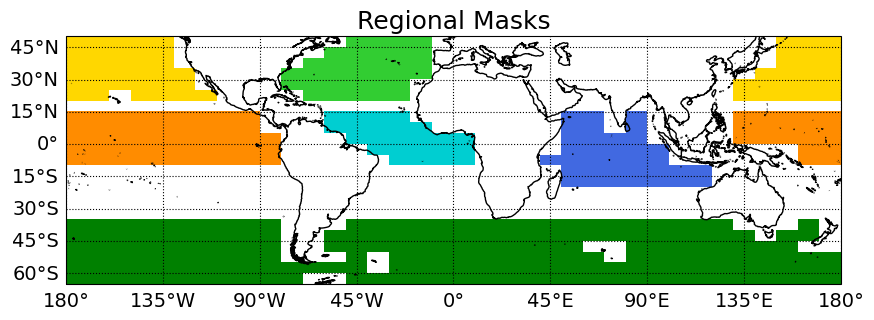

In [5]:
# Regional masks
# Using grid cell numbers:
masks = np.zeros(shape = np.shape(grid_cell_numbers))
# Tropical Atlantic
masks[16,15:19] = 1
masks[17,14:19] = 1
masks[18,13:19] = 1
masks[19,12:17] = 1
masks[20,12:16] = 1

# Extratropical Atlantic
masks[22,11:16] = 2
masks[23,10:16] = 2
masks[24,10:17] = 2
masks[25,11:17] = 2
masks[26,12:17] = 2
masks[27,13:17] = 2

# Extratropical Pacific
masks[22,:2] = 3
masks[22,3:7] = 3
masks[23,:6] = 3
masks[24,:6] = 3
masks[25,:5] = 3
masks[26,:5] = 3
masks[27,:5] = 3
masks[22,-5:] = 3
masks[23,-5:] = 3
masks[24,-4:] = 3
masks[25,-3:] = 3
masks[26,-3:] = 3
masks[27,-3:] = 3

# Orography mask(for the Southern Ocean data)
orog_mask = np.zeros(shape = np.shape(grid_cell_numbers))
# South America
orog_mask[7:11,10:12] = 1
orog_mask[10,12] = 1
# Islands
orog_mask[7,12] = 1
orog_mask[6,14] = 1
orog_mask[7,14] = 1
orog_mask[7,25] = 1
orog_mask[8,24:26] = 1
# Tazmania, Australia, New Zealand
orog_mask[9,32] = 1
orog_mask[10,31:34] = 1
orog_mask[8:11,35] = 1
orog_mask[8,34] = 1
# Antarctica
orog_mask[5,11:13] = 1
# Eliminate the Southern Ocean data over orography
orog_cell_numbers = grid_cell_numbers[orog_mask==1]

# For plotting a map of the masks
# Indian Ocean:
masks[14,23:30] = 4
masks[15,23:30] = 4
masks[16,22:28] = 4
masks[17,23:28] = 4
masks[18,23:27] = 4
masks[19,23:25] = 4
masks[19,26:27] = 4
masks[20,23:25] = 4
masks[20,26:27] = 4
# Tropical Pacific:
masks[16,34:] = 5
masks[17,34:] = 5
masks[18,31:] = 5
masks[19,31:] = 5
masks[20,31:] = 5
masks[16,:10] = 5
masks[17,:10] = 5
masks[18,:10] = 5
masks[19,:9] = 5
masks[20,:9] = 5
# Southern Ocean:
masks[10,:] = 6
masks[9,:] = 6
masks[8,:] = 6
masks[7,:] = 6
masks[6,:] = 6
masks[5,:] = 6
masks[orog_mask == 1] = 0

# Select the flights
trop_atl_flights = flights[flights.grid_cell_number.isin(
    grid_cell_numbers[masks == 1])].copy()
extra_atl_flights = flights[flights.grid_cell_number.isin(
    grid_cell_numbers[masks == 2])].copy()
extra_pac_flights = flights[flights.grid_cell_number.isin(
    grid_cell_numbers[masks == 3])].copy()
indian_flights = flights[flights.grid_cell_number.isin(
    grid_cell_numbers[masks == 4])].copy()
trop_pac_flights = flights[flights.grid_cell_number.isin(
    grid_cell_numbers[masks == 5])].copy()
SO_flights = flights[flights.grid_cell_number.isin(
    grid_cell_numbers[masks == 6])].copy()

# Paper Figure 3, top panel
cmap = matplotlib.colors.ListedColormap([matplotlib.colors.CSS4_COLORS['darkturquoise'],
                                         matplotlib.colors.CSS4_COLORS['limegreen'],
                                         matplotlib.colors.CSS4_COLORS['gold'],
                                         matplotlib.colors.CSS4_COLORS['royalblue'],
                                         matplotlib.colors.CSS4_COLORS['darkorange'],
                                         matplotlib.colors.CSS4_COLORS['green']])

plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -65, 50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,15))
data = masks[:,:].copy()
data[data == 0] = np.nan
plt.imshow(data, cmap=cmap, extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.title('Regional Masks', fontsize=18);
#plt.savefig('temp11.pdf', format='pdf', bbox_inches='tight');

print(indian_flights.shape[0], trop_pac_flights.shape[0], SO_flights.shape[0], trop_atl_flights.shape[0], 
      extra_atl_flights.shape[0], extra_pac_flights.shape[0])

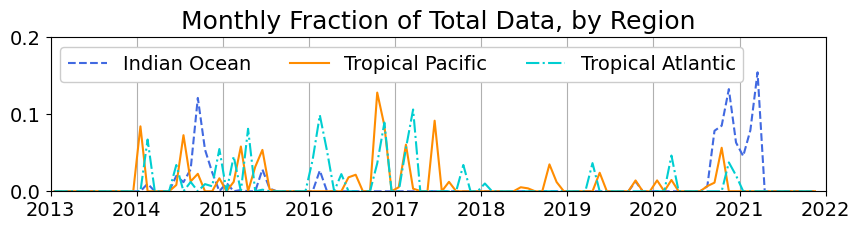

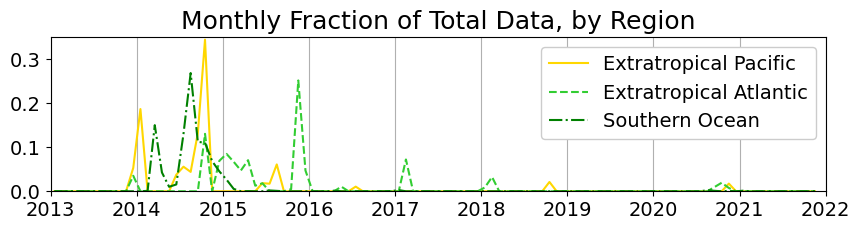

In [6]:
# Paper Figure 3, bottom panels

bins = bins = 2013 + np.arange(9*12)/12

temp_time = -1/24 + np.array(indian_flights.time.dt.month)/12
temp_time = temp_time + np.array(indian_flights.time.dt.year)
hist_all1, _ = np.histogram(temp_time, bins = bins)

temp_time = -1/24 + np.array(trop_pac_flights.time.dt.month)/12
temp_time = temp_time + np.array(trop_pac_flights.time.dt.year)
hist_all2, _ = np.histogram(temp_time, bins = bins)

temp_time = -1/24 + np.array(extra_pac_flights.time.dt.month)/12
temp_time = temp_time + np.array(extra_pac_flights.time.dt.year)
hist_all3, _ = np.histogram(temp_time, bins = bins)

temp_time = -1/24 + np.array(trop_atl_flights.time.dt.month)/12
temp_time = temp_time + np.array(trop_atl_flights.time.dt.year)
hist_all4, _ = np.histogram(temp_time, bins = bins)

temp_time = -1/24 + np.array(extra_atl_flights.time.dt.month)/12
temp_time = temp_time + np.array(extra_atl_flights.time.dt.year)
hist_all5, _ = np.histogram(temp_time, bins = bins)

temp_time = -1/24 + np.array(SO_flights.time.dt.month)/12
temp_time = temp_time + np.array(SO_flights.time.dt.year)
hist_all6, _ = np.histogram(temp_time, bins = bins)

plt.figure(figsize=(10,2))
plt.plot(0.5*(bins[1:] + bins[:-1]),hist_all1/np.sum(hist_all1),
         matplotlib.colors.CSS4_COLORS['royalblue'], linestyle='dashed')
plt.plot(0.5*(bins[1:] + bins[:-1]),hist_all2/np.sum(hist_all2),
         matplotlib.colors.CSS4_COLORS['darkorange'], linestyle='solid')
plt.plot(0.5*(bins[1:] + bins[:-1]),hist_all4/np.sum(hist_all4),
         matplotlib.colors.CSS4_COLORS['darkturquoise'], linestyle='dashdot')
plt.grid(axis='x')
plt.xlim(2013,2022)
plt.ylim(0,0.2)
plt.xticks(fontsize=14)
plt.yticks([0,0.1,0.2],fontsize=14)
plt.title('Monthly Fraction of Total Data, by Region',fontsize=18)
plt.legend(['Indian Ocean','Tropical Pacific','Tropical Atlantic'],
           bbox_to_anchor=(0.0, 1.0), loc='upper left',
           fancybox=True, framealpha=1, fontsize=14, ncol=3);
#plt.savefig('temp2.pdf', format='pdf', bbox_inches='tight');

plt.figure(figsize=(10,2))
plt.plot(0.5*(bins[1:] + bins[:-1]),hist_all3/np.sum(hist_all3),
         matplotlib.colors.CSS4_COLORS['gold'], linestyle='solid')
plt.plot(0.5*(bins[1:] + bins[:-1]),hist_all5/np.sum(hist_all5),
         matplotlib.colors.CSS4_COLORS['limegreen'], linestyle='dashed')
plt.plot(0.5*(bins[1:] + bins[:-1]),hist_all6/np.sum(hist_all6),
         matplotlib.colors.CSS4_COLORS['green'], linestyle='dashdot')
plt.grid(axis='x')
plt.xlim(2013,2022)
plt.ylim(0,0.35)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Monthly Fraction of Total Data, by Region',fontsize=18)
plt.legend(['Extratropical Pacific','Extratropical Atlantic','Southern Ocean'],
           framealpha=1,fontsize=14);
#plt.savefig('temp3.pdf', format='pdf', bbox_inches='tight');

In [14]:
# Calculations supporting the discussion of seasonal sampling biases

# Fraction of the the data in the extratropical Atlantic collected November-February
temp = extra_atl_flights.copy()
print('Mean latitude:', temp.latitude.mean())
temp2 = temp[temp.time.dt.month >= 11]
temp = temp[temp.time.dt.month <= 2]
print('Percent:', 100*(temp.shape[0] + temp2.shape[0])/extra_atl_flights.shape[0])
print('')

# Fraction of the the data in the extratropical Pacific collected DJF
temp = extra_pac_flights.copy()
print('Mean latitude:', temp.latitude.mean())
temp2 = temp[temp.time.dt.month >= 12]
temp = temp[temp.time.dt.month <= 2]
print('Percent DJF:', 100*(temp.shape[0] + temp2.shape[0])/extra_pac_flights.shape[0])

# Fraction of the the data in the extratropical Pacific collected MAM
temp = extra_pac_flights.copy()
temp = temp[temp.time.dt.month >= 3]
temp = temp[temp.time.dt.month <= 5]
print('Percent MAM:', 100*(temp.shape[0])/extra_pac_flights.shape[0])

# Fraction of the the data in the extratropical Pacific collected JJA
temp = extra_pac_flights.copy()
temp = temp[temp.time.dt.month >= 6]
temp = temp[temp.time.dt.month <= 8]
print('Percent JJA:', 100*(temp.shape[0])/extra_pac_flights.shape[0])

# Fraction of the the data in the extratropical Pacific collected SON
temp = extra_pac_flights.copy()
temp = temp[temp.time.dt.month >= 9]
temp = temp[temp.time.dt.month <= 11]
print('Percent SON:', 100*(temp.shape[0])/extra_pac_flights.shape[0])

Mean latitude: 29.199604397495946
Percent: 67.6364536199095

Mean latitude: 32.71018311050245
Percent DJF: 23.993691331806893
Percent MAM: 0.0
Percent JJA: 24.501428442962585
Percent SON: 51.50488022523052


In [7]:
# Calculations supporting Tables 1 and 3

temp_flights = indian_flights.copy()
print('Indian Ocean')
print('Number of data points:', temp_flights.shape[0])
print('Time mean zonal momentum flux (mPa):', 1000*(temp_flights.flux_east + temp_flights.flux_west).mean())
print('Time mean eastward momentum flux (mPa):', 1000*temp_flights.flux_east.mean())
print('Time mean westward momentum flux (mPa):', -1000*temp_flights.flux_west.mean())
temp = np.log10(np.array(1000*temp_flights.flux_east))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the eastward flux in mPa:', np.mean(temp), np.std(temp))
temp = np.log10(np.array(-1000*temp_flights.flux_west))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the westward flux in mPa:', np.mean(temp), np.std(temp))
print('')

temp_flights = trop_pac_flights.copy()
print('Tropical Pacific')
print('Number of data points:', temp_flights.shape[0])
print('Time mean zonal momentum flux (mPa):', 1000*(temp_flights.flux_east + temp_flights.flux_west).mean())
print('Time mean eastward momentum flux (mPa):', 1000*temp_flights.flux_east.mean())
print('Time mean westward momentum flux (mPa):', -1000*temp_flights.flux_west.mean())
temp = np.log10(np.array(1000*temp_flights.flux_east))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the eastward flux in mPa:', np.mean(temp), np.std(temp))
temp = np.log10(np.array(-1000*temp_flights.flux_west))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the westward flux in mPa:', np.mean(temp), np.std(temp))
print('')

temp_flights = extra_pac_flights.copy()
print('Extratropical Pacific')
print('Number of data points:', temp_flights.shape[0])
print('Time mean zonal momentum flux (mPa):', 1000*(temp_flights.flux_east + temp_flights.flux_west).mean())
print('Time mean eastward momentum flux (mPa):', 1000*temp_flights.flux_east.mean())
print('Time mean westward momentum flux (mPa):', -1000*temp_flights.flux_west.mean())
temp = np.log10(np.array(1000*temp_flights.flux_east))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the eastward flux in mPa:', np.mean(temp), np.std(temp))
temp = np.log10(np.array(-1000*temp_flights.flux_west))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the westward flux in mPa:', np.mean(temp), np.std(temp))
print('')

temp_flights = trop_atl_flights.copy()
print('Tropical Atlantic')
print('Number of data points:', temp_flights.shape[0])
print('Time mean zonal momentum flux (mPa):', 1000*(temp_flights.flux_east + temp_flights.flux_west).mean())
print('Time mean eastward momentum flux (mPa):', 1000*temp_flights.flux_east.mean())
print('Time mean westward momentum flux (mPa):', -1000*temp_flights.flux_west.mean())
temp = np.log10(np.array(1000*temp_flights.flux_east))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the eastward flux in mPa:', np.mean(temp), np.std(temp))
temp = np.log10(np.array(-1000*temp_flights.flux_west))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the westward flux in mPa:', np.mean(temp), np.std(temp))
print('')

temp_flights = extra_atl_flights.copy()
print('Extratropical Atlantic')
print('Number of data points:', temp_flights.shape[0])
print('Time mean zonal momentum flux (mPa):', 1000*(temp_flights.flux_east + temp_flights.flux_west).mean())
print('Time mean eastward momentum flux (mPa):', 1000*temp_flights.flux_east.mean())
print('Time mean westward momentum flux (mPa):', -1000*temp_flights.flux_west.mean())
temp = np.log10(np.array(1000*temp_flights.flux_east))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the eastward flux in mPa:', np.mean(temp), np.std(temp))
temp = np.log10(np.array(-1000*temp_flights.flux_west))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the westward flux in mPa:', np.mean(temp), np.std(temp))
print('')

temp_flights = SO_flights.copy()
print('Southern Ocean')
print('Number of data points:', temp_flights.shape[0])
print('Time mean zonal momentum flux (mPa):', 1000*(temp_flights.flux_east + temp_flights.flux_west).mean())
print('Time mean eastward momentum flux (mPa):', 1000*temp_flights.flux_east.mean())
print('Time mean westward momentum flux (mPa):', -1000*temp_flights.flux_west.mean())
temp = np.log10(np.array(1000*temp_flights.flux_east))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the eastward flux in mPa:', np.mean(temp), np.std(temp))
temp = np.log10(np.array(-1000*temp_flights.flux_west))
temp = temp[np.isfinite(temp) == 1]
print('Mean, Sigma of log10 of the westward flux in mPa:', np.mean(temp), np.std(temp))
print('')

Indian Ocean
Number of data points: 144683
Time mean zonal momentum flux (mPa): 0.21015190914437593
Time mean eastward momentum flux (mPa): 1.422977425977184
Time mean westward momentum flux (mPa): 1.2128255168328081
Mean, Sigma of log10 of the eastward flux in mPa: -0.06688123277239674 0.46944280375446795
Mean, Sigma of log10 of the westward flux in mPa: -0.09438752531698495 0.42037946915655133

Tropical Pacific
Number of data points: 169358
Time mean zonal momentum flux (mPa): 0.0672412771863453
Time mean eastward momentum flux (mPa): 1.4142116399961817
Time mean westward momentum flux (mPa): 1.3469703628098364
Mean, Sigma of log10 of the eastward flux in mPa: -0.09708321349423149 0.4794997983802937
Mean, Sigma of log10 of the westward flux in mPa: -0.1077176114329226 0.4708241593149533

Extratropical Pacific
Number of data points: 144563
Time mean zonal momentum flux (mPa): 0.21736477313610353
Time mean eastward momentum flux (mPa): 1.2123765513130813
Time mean westward momentum flu

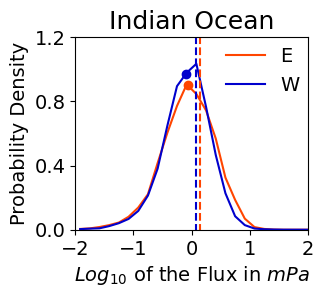

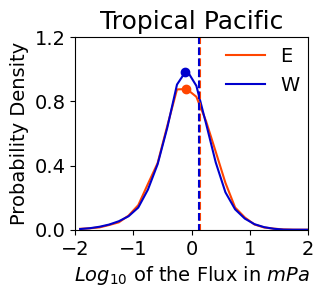

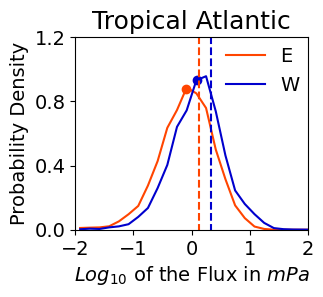

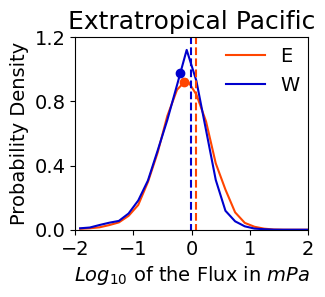

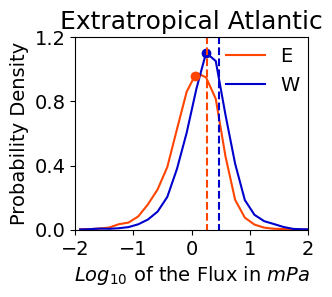

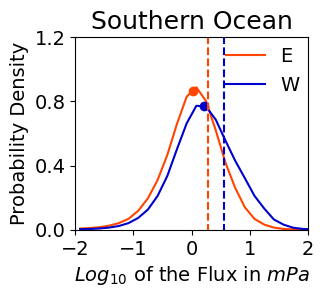

In [8]:
# Panels in paper Figure 4

bins_log10_flux = -2 + np.arange(31)*(5/30)



temp_flights = indian_flights.copy()
temp1 = np.array(np.log10(1000*temp_flights.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(3,2.5))
plt.plot(bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['mediumblue'])
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['orangered'],markersize=6)
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumblue'],markersize=6)
plt.plot([np.log10(1000*temp_flights.flux_east.mean()),np.log10(1000*temp_flights.flux_east.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights.flux_west.mean()),np.log10(-1000*temp_flights.flux_west.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['mediumblue'],linestyle='dashed')
plt.xlim(-2,2)
plt.ylim(0,1.2)
plt.xticks([-2,-1,0,1,2], fontsize=14)
plt.yticks([0,0.4,0.8,1.2], fontsize=14)
plt.title('Indian Ocean', fontsize=18)
plt.xlabel('$Log_{10}$ of the Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['E','W'],bbox_to_anchor=(1.04,1.04),loc='upper right',framealpha=0, fontsize=14);
#plt.savefig('temp1.pdf', format='pdf', bbox_inches='tight');



temp_flights = trop_pac_flights.copy()
temp1 = np.array(np.log10(1000*temp_flights.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(3,2.5))
plt.plot(bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['mediumblue'])
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['orangered'],markersize=6)
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumblue'],markersize=6)
plt.plot([np.log10(1000*temp_flights.flux_east.mean()),np.log10(1000*temp_flights.flux_east.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights.flux_west.mean()),np.log10(-1000*temp_flights.flux_west.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['mediumblue'],linestyle='dashed')
plt.xlim(-2,2)
plt.ylim(0,1.2)
plt.xticks([-2,-1,0,1,2], fontsize=14)
plt.yticks([0,0.4,0.8,1.2], fontsize=14)
plt.title('Tropical Pacific', fontsize=18)
plt.xlabel('$Log_{10}$ of the Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['E','W'],bbox_to_anchor=(1.04,1.04),loc='upper right',framealpha=0, fontsize=14);
#plt.savefig('temp2.pdf', format='pdf', bbox_inches='tight');



temp_flights = trop_atl_flights.copy()
temp1 = np.array(np.log10(1000*temp_flights.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(3,2.5))
plt.plot(bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['mediumblue'])
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['orangered'],markersize=6)
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumblue'],markersize=6)
plt.plot([np.log10(1000*temp_flights.flux_east.mean()),np.log10(1000*temp_flights.flux_east.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights.flux_west.mean()),np.log10(-1000*temp_flights.flux_west.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['mediumblue'],linestyle='dashed')
plt.xlim(-2,2)
plt.ylim(0,1.2)
plt.xticks([-2,-1,0,1,2], fontsize=14)
plt.yticks([0,0.4,0.8,1.2], fontsize=14)
plt.title('Tropical Atlantic', fontsize=18)
plt.xlabel('$Log_{10}$ of the Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['E','W'],bbox_to_anchor=(1.04,1.04),loc='upper right',framealpha=0, fontsize=14);
#plt.savefig('temp3.pdf', format='pdf', bbox_inches='tight');



temp_flights = extra_pac_flights.copy()
temp1 = np.array(np.log10(1000*temp_flights.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(3,2.5))
plt.plot(bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['mediumblue'])
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['orangered'],markersize=6)
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumblue'],markersize=6)
plt.plot([np.log10(1000*temp_flights.flux_east.mean()),np.log10(1000*temp_flights.flux_east.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights.flux_west.mean()),np.log10(-1000*temp_flights.flux_west.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['mediumblue'],linestyle='dashed')
plt.xlim(-2,2)
plt.ylim(0,1.2)
plt.xticks([-2,-1,0,1,2], fontsize=14)
plt.yticks([0,0.4,0.8,1.2], fontsize=14)
plt.title('Extratropical Pacific', fontsize=18)
plt.xlabel('$Log_{10}$ of the Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['E','W'],bbox_to_anchor=(1.04,1.04),loc='upper right',framealpha=0, fontsize=14);
#plt.savefig('temp4.pdf', format='pdf', bbox_inches='tight');



temp_flights = extra_atl_flights.copy()
temp1 = np.array(np.log10(1000*temp_flights.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(3,2.5))
plt.plot(bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['mediumblue'])
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['orangered'],markersize=6)
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumblue'],markersize=6)
plt.plot([np.log10(1000*temp_flights.flux_east.mean()),np.log10(1000*temp_flights.flux_east.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights.flux_west.mean()),np.log10(-1000*temp_flights.flux_west.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['mediumblue'],linestyle='dashed')
plt.xlim(-2,2)
plt.ylim(0,1.2)
plt.xticks([-2,-1,0,1,2], fontsize=14)
plt.yticks([0,0.4,0.8,1.2], fontsize=14)
plt.title('Extratropical Atlantic', fontsize=18)
plt.xlabel('$Log_{10}$ of the Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['E','W'],bbox_to_anchor=(1.04,1.04),loc='upper right',framealpha=0, fontsize=14);
#plt.savefig('temp5.pdf', format='pdf', bbox_inches='tight');



temp_flights = SO_flights.copy()
temp1 = np.array(np.log10(1000*temp_flights.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(3,2.5))
plt.plot(bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0])),
         matplotlib.colors.CSS4_COLORS['mediumblue'])
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['orangered'],markersize=6)
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumblue'],markersize=6)
plt.plot([np.log10(1000*temp_flights.flux_east.mean()),np.log10(1000*temp_flights.flux_east.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights.flux_west.mean()),np.log10(-1000*temp_flights.flux_west.mean())],[-1,2],
         matplotlib.colors.CSS4_COLORS['mediumblue'],linestyle='dashed')
plt.xlim(-2,2)
plt.ylim(0,1.2)
plt.xticks([-2,-1,0,1,2], fontsize=14)
plt.yticks([0,0.4,0.8,1.2], fontsize=14)
plt.title('Southern Ocean', fontsize=18)
plt.xlabel('$Log_{10}$ of the Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['E','W'],bbox_to_anchor=(1.04,1.04),loc='upper right',framealpha=0, fontsize=14);
#plt.savefig('temp6.pdf', format='pdf', bbox_inches='tight');

In [9]:
# Calculations supporting Tables 1 and 2

# Percentiles for calculating the intermittency of the distributions
# NOTE: THESE ARE NOT THE INTERMITTENCIES USED IN FIGURE 5
int_pct1 = 0.5 # dummy variable; not used in paper
int_pct2 = 0.99



# Indian Ocean
# Calculate the distributions of the log10 of the eastward and westward fluxes
temp_flights = indian_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)
int_fluxE = flux_pct1E/flux_pct2E

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)
int_fluxW = flux_pct1W/flux_pct2W

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted = flux_pct1E_shifted/flux_pct2E_shifted

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted = flux_pct1W_shifted/flux_pct2W_shifted

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_squeezed = flux_pct1E_squeezed/flux_pct2E_squeezed

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_squeezed = flux_pct1W_squeezed/flux_pct2W_squeezed

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted_squeezed = flux_pct1E_shifted_squeezed/flux_pct2E_shifted_squeezed

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted_squeezed = flux_pct1W_shifted_squeezed/flux_pct2W_shifted_squeezed

# The fraction of the total flux explained by the 99th percentile
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2E = np.sum(temp[temp > temp2])/(np.sum(temp))

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2W = np.sum(temp[temp > temp2])/(np.sum(temp))

print('Indian Ocean')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('Percent of Eastward, Westward Fluxes Due to > 99th Percentile:', 100*frac_pct2E, 100*frac_pct2W)
print('')
print('')







# Tropical Pacific
# Calculate the distributions of the log10 of the eastward and westward fluxes
temp_flights = trop_pac_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)
int_fluxE = flux_pct1E/flux_pct2E

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)
int_fluxW = flux_pct1W/flux_pct2W

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted = flux_pct1E_shifted/flux_pct2E_shifted

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted = flux_pct1W_shifted/flux_pct2W_shifted

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_squeezed = flux_pct1E_squeezed/flux_pct2E_squeezed

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_squeezed = flux_pct1W_squeezed/flux_pct2W_squeezed

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted_squeezed = flux_pct1E_shifted_squeezed/flux_pct2E_shifted_squeezed

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted_squeezed = flux_pct1W_shifted_squeezed/flux_pct2W_shifted_squeezed

# The fraction of the total flux explained by the 99th percentile
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2E = np.sum(temp[temp > temp2])/(np.sum(temp))

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2W = np.sum(temp[temp > temp2])/(np.sum(temp))

print('Tropical Pacific')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('Percent of Eastward, Westward Fluxes Due to > 99th Percentile:', 100*frac_pct2E, 100*frac_pct2W)
print('')
print('')







# Extratropical Pacific
# Calculate the distributions of the log10 of the eastward and westward fluxes
temp_flights = extra_pac_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)
int_fluxE = flux_pct1E/flux_pct2E

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)
int_fluxW = flux_pct1W/flux_pct2W

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted = flux_pct1E_shifted/flux_pct2E_shifted

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted = flux_pct1W_shifted/flux_pct2W_shifted

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_squeezed = flux_pct1E_squeezed/flux_pct2E_squeezed

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_squeezed = flux_pct1W_squeezed/flux_pct2W_squeezed

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted_squeezed = flux_pct1E_shifted_squeezed/flux_pct2E_shifted_squeezed

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted_squeezed = flux_pct1W_shifted_squeezed/flux_pct2W_shifted_squeezed

# The fraction of the total flux explained by the 99th percentile
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2E = np.sum(temp[temp > temp2])/(np.sum(temp))

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2W = np.sum(temp[temp > temp2])/(np.sum(temp))

print('Extratropical Pacific')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('Percent of Eastward, Westward Fluxes Due to > 99th Percentile:', 100*frac_pct2E, 100*frac_pct2W)
print('')
print('')







# Tropical Atlantic
# Calculate the distributions of the log10 of the eastward and westward fluxes
temp_flights = trop_atl_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)
int_fluxE = flux_pct1E/flux_pct2E

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)
int_fluxW = flux_pct1W/flux_pct2W

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted = flux_pct1E_shifted/flux_pct2E_shifted

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted = flux_pct1W_shifted/flux_pct2W_shifted

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_squeezed = flux_pct1E_squeezed/flux_pct2E_squeezed

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_squeezed = flux_pct1W_squeezed/flux_pct2W_squeezed

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted_squeezed = flux_pct1E_shifted_squeezed/flux_pct2E_shifted_squeezed

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted_squeezed = flux_pct1W_shifted_squeezed/flux_pct2W_shifted_squeezed

# The fraction of the total flux explained by the 99th percentile
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2E = np.sum(temp[temp > temp2])/(np.sum(temp))

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2W = np.sum(temp[temp > temp2])/(np.sum(temp))

print('Tropical Atlantic')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('Percent of Eastward, Westward Fluxes Due to > 99th Percentile:', 100*frac_pct2E, 100*frac_pct2W)
print('')
print('')







# Extratropical Atlantic
# Calculate the distributions of the log10 of the eastward and westward fluxes
temp_flights = extra_atl_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)
int_fluxE = flux_pct1E/flux_pct2E

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)
int_fluxW = flux_pct1W/flux_pct2W

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted = flux_pct1E_shifted/flux_pct2E_shifted

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted = flux_pct1W_shifted/flux_pct2W_shifted

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_squeezed = flux_pct1E_squeezed/flux_pct2E_squeezed

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_squeezed = flux_pct1W_squeezed/flux_pct2W_squeezed

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted_squeezed = flux_pct1E_shifted_squeezed/flux_pct2E_shifted_squeezed

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted_squeezed = flux_pct1W_shifted_squeezed/flux_pct2W_shifted_squeezed

# The fraction of the total flux explained by the 99th percentile
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2E = np.sum(temp[temp > temp2])/(np.sum(temp))

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2W = np.sum(temp[temp > temp2])/(np.sum(temp))

print('Extratropical Atlantic')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('Percent of Eastward, Westward Fluxes Due to > 99th Percentile:', 100*frac_pct2E, 100*frac_pct2W)
print('')
print('')







# Southern Ocean
# Calculate the distributions of the log10 of the eastward and westward fluxes
temp_flights = SO_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)
int_fluxE = flux_pct1E/flux_pct2E

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)
int_fluxW = flux_pct1W/flux_pct2W

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted = flux_pct1E_shifted/flux_pct2E_shifted

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted = flux_pct1W_shifted/flux_pct2W_shifted

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_squeezed = flux_pct1E_squeezed/flux_pct2E_squeezed

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_squeezed = flux_pct1W_squeezed/flux_pct2W_squeezed

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxE_shifted_squeezed = flux_pct1E_shifted_squeezed/flux_pct2E_shifted_squeezed

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)
int_fluxW_shifted_squeezed = flux_pct1W_shifted_squeezed/flux_pct2W_shifted_squeezed

# The fraction of the total flux explained by the 99th percentile
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2E = np.sum(temp[temp > temp2])/(np.sum(temp))

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
temp2 = np.interp(int_pct2,percentiles,temp)
frac_pct2W = np.sum(temp[temp > temp2])/(np.sum(temp))

print('Southern Ocean')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('Percent of Eastward, Westward Fluxes Due to > 99th Percentile:', 100*frac_pct2E, 100*frac_pct2W)
print('')
print('')

Indian Ocean
Eastward, Westward Mean Flux (mPa): 1.4229774259772323 1.212825516832857
Shifted E, Shifted W (mPa):         1.336265876583291 1.2931262813230053
Squeezed E, Squeezed W (mPa):       1.2935291256133419 1.339189972582576
Sh+Sq E, Sh_Sq W (mPa):             1.214143220966933 1.4267519715551524
Difference, E-W (mPa):              0.21015190914437532
for E - shE, shW - W (mPa):         0.08671154939394121 0.08030076449014834
for E - sqE, sqW - W (mPa):         0.12944830036389043 0.126364455749719
for E - sh+sqE, sh+sqW - W (mPa):   0.20883420501029937 0.21392645472229543
% explained by E - shE, shW - W:        39.73609246855601
% explained by E - sqE, sqW - W:        60.86377162956557
% explained by E - sh+sqE, sh+sqW - W : 100.58453940624358

99th Percentile Eastward, Westward Flux (mPa): 7.8226402316945665 6.120457521791231
for shifted distributions:                     7.3435906588463595 6.5218021257362135
for squeezed distributions:                    6.2094109065650684 7.

Southern Ocean
Eastward, Westward Mean Flux (mPa): 1.9501423719154005 3.5705619277866156
Shifted E, Shifted W (mPa):         3.078156061662882 2.2673475171166193
Squeezed E, Squeezed W (mPa):       2.15019465312861 3.2210420870791396
Sh+Sq E, Sh_Sq W (mPa):             3.388497772076396 2.0439344922147518
Difference, E-W (mPa):              -1.6204195558712151
for E - shE, shW - W (mPa):         -1.1280136897474813 -1.3032144106699963
for E - sqE, sqW - W (mPa):         -0.20005228121320928 -0.349519840707476
for E - sh+sqE, sh+sqW - W (mPa):   -1.4383554001609953 -1.5266274355718639
% explained by E - shE, shW - W:        75.01847566602383
% explained by E - sqE, sqW - W:        16.957710733909558
% explained by E - sh+sqE, sh+sqW - W : 91.48812185677254

99th Percentile Eastward, Westward Flux (mPa): 13.809840408684233 29.468011308848773
for shifted distributions:                     21.782693211377186 18.705642251889536
for squeezed distributions:                    16.7924705627882

In [18]:
# Calculations supporting the discussions of inter-regional differences in section 4.1 of the paper

# Tropical Atlantic Westward Fluxes - Tropical Pacific Westward Fluxes
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = trop_atl_flights.copy()
fluxE = np.array(-1000*temp_flights.flux_west)
temp_flights = trop_pac_flights.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

# Calculate the intermittency of the distributions
temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: Tropical Atlantic Westward Fluxes, W: Tropical Pacific Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('')
print('')







# Extratropical Atlantic Westward Fluxes - Extratropical Pacific Westward Fluxes
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = extra_atl_flights.copy()
fluxE = np.array(-1000*temp_flights.flux_west)
temp_flights = extra_pac_flights.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: Extratropical Atlantic Westward Fluxes, W: Extratropical Pacific Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('')
print('')







# Extratropical Atlantic Eastward Fluxes - Extratropical Pacific Eastward Fluxes
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = extra_atl_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = extra_pac_flights.copy()
fluxW = np.array(1000*temp_flights.flux_east)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: Extratropical Atlantic Eastward Fluxes, W: Extratropical Pacific Eastward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print(f'{int(np.round(100*int_pct2))}th Percentile Eastward, Westward Flux (mPa):', flux_pct2E, flux_pct2W)
print('for shifted distributions:                    ', flux_pct2E_shifted, flux_pct2W_shifted)
print('for squeezed distributions:                   ', flux_pct2E_squeezed, flux_pct2W_squeezed)
print('for shifted_squeezed distributions:           ', flux_pct2E_shifted_squeezed, flux_pct2W_shifted_squeezed)
print('Difference, E-W (mPa):                        ', flux_pct2E - flux_pct2W)
print('for E - shE, shW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_shifted, 
      flux_pct2W_shifted - flux_pct2W)
print('for E - sqE, sqW - W (mPa):                   ',
      flux_pct2E - flux_pct2E_squeezed, 
      flux_pct2W_squeezed - flux_pct2W)
print('for E - sh+sqE, sh+sqW - W (mPa):             ',
      flux_pct2E - flux_pct2E_shifted_squeezed, 
      flux_pct2W_shifted_squeezed - flux_pct2W)
print('% explained by E - shE, shW - W:              ',
      100*((flux_pct2E - flux_pct2E_shifted) + (flux_pct2W_shifted - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sqE, sqW - W:              ',
      100*((flux_pct2E - flux_pct2E_squeezed) + (flux_pct2W_squeezed - flux_pct2W))/(2*(flux_pct2E - flux_pct2W)))
print('% explained by E - sh+sqE, sh+sqW - W:        ',
      100*((flux_pct2E - flux_pct2E_shifted_squeezed) + (flux_pct2W_shifted_squeezed - flux_pct2W))/
      (2*(flux_pct2E - flux_pct2W)))
print('')
print('')

E: Tropical Atlantic Westward Fluxes, W: Tropical Pacific Westward Fluxes
Eastward, Westward Mean Flux (mPa): 2.154007480015217 1.3469703628098848
Shifted E, Shifted W (mPa):         1.351075579668103 2.1502300841404405
Squeezed E, Squeezed W (mPa):       2.188825046396798 1.3280366083171928
Sh+Sq E, Sh_Sq W (mPa):             1.3726712034125856 2.117651906436048
Difference, E-W (mPa):              0.8070371172053321
for E - shE, shW - W (mPa):         0.8029319003471138 0.8032597213305557
for E - sqE, sqW - W (mPa):         -0.03481756638158107 -0.018933754492691968
for E - sh+sqE, sh+sqW - W (mPa):   0.7813362766026313 0.7706815436261631
% explained by E - shE, shW - W:        99.51163257767553
% explained by E - sqE, sqW - W:        -3.3301641106921505
% explained by E - sh+sqE, sh+sqW - W : 96.15529367492023

99th Percentile Eastward, Westward Flux (mPa): 14.51295189251896 9.70519380673346
for shifted distributions:                     9.102477651395251 15.47866869311509
for squeez

Southern Ocean
Predicted 90th percentile flux (mPa): 14.98695078569424
Actual 90th percentile flux (mPa): 18.33252455536199
Percent occurance of fluxes above the predicted 90th percentile value: 13.842663497742715
Percent occurance of fluxes above the actual 90th percentile value: 10.000057200793375
Percent difference between the predicted and actual intermittency: 22.323245185146394

[0.2589833  0.29841583 0.31450737 0.27802747 0.26822707 0.37636815]
[0.45603516 0.38125954 0.34201308 0.41297379 0.45579804 0.26925006]


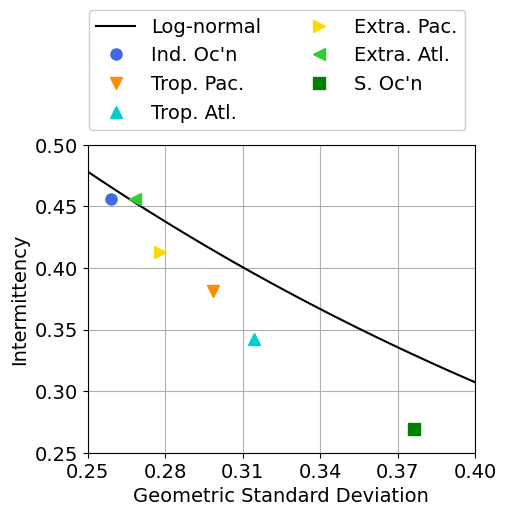

In [7]:
# Calculations that produce Figure 5

int_pct1 = 0.5
int_pct2 = 0.9
intermittency = np.nan*np.ones(6)
mean_flux = np.nan*np.ones(6)
sigma_flux = np.nan*np.ones(6)
skew_flux = np.nan*np.ones(6)
kurtosis_flux = np.nan*np.ones(6)

# Indian Ocean
temp_flights = indian_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
# Calculate the intermittency of the distributions
temp = np.sort(fluxTot)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)
# Calculate the mean flux and the intermittency
intermittency[0] = flux_pct1/flux_pct2
mean_flux[0] = np.nanmean(fluxTot)
sigma_flux[0] = np.std(np.log10(fluxTot))
skew_flux[0] = skew(np.log10(fluxTot))
kurtosis_flux[0] = kurtosis(np.log10(fluxTot),fisher=True)

# Tropical Pacific
temp_flights = trop_pac_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
# Calculate the intermittency of the distributions
temp = np.sort(fluxTot)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)
# Calculate the mean flux and the intermittency
intermittency[1] = flux_pct1/flux_pct2
mean_flux[1] = np.nanmean(fluxTot)
sigma_flux[1] = np.std(np.log10(fluxTot))
skew_flux[1] = skew(np.log10(fluxTot))
kurtosis_flux[1] = kurtosis(np.log10(fluxTot),fisher=True)

# Tropical Atlantic
temp_flights = trop_atl_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
# Calculate the intermittency of the distributions
temp = np.sort(fluxTot)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)
# Calculate the mean flux and the intermittency
intermittency[2] = flux_pct1/flux_pct2
mean_flux[2] = np.nanmean(fluxTot)
sigma_flux[2] = np.std(np.log10(fluxTot))
skew_flux[2] = skew(np.log10(fluxTot))
kurtosis_flux[2] = kurtosis(np.log10(fluxTot),fisher=True)

# Extratropical Pacific
temp_flights = extra_pac_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
# Calculate the intermittency of the distributions
temp = np.sort(fluxTot)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)
# Calculate the mean flux and the intermittency
intermittency[3] = flux_pct1/flux_pct2
mean_flux[3] = np.nanmean(fluxTot)
sigma_flux[3] = np.std(np.log10(fluxTot))
skew_flux[3] = skew(np.log10(fluxTot))
kurtosis_flux[3] = kurtosis(np.log10(fluxTot),fisher=True)

# Extratropical Atlantic
temp_flights = extra_atl_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
# Calculate the intermittency of the distributions
temp = np.sort(fluxTot)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)
# Calculate the mean flux and the intermittency
intermittency[4] = flux_pct1/flux_pct2
mean_flux[4] = np.nanmean(fluxTot)
sigma_flux[4] = np.std(np.log10(fluxTot))
skew_flux[4] = skew(np.log10(fluxTot))
kurtosis_flux[4] = kurtosis(np.log10(fluxTot),fisher=True)

# Southern Ocean
temp_flights = SO_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
# Calculate the intermittency of the distributions
temp = np.sort(fluxTot)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)
# Calculate the mean flux and the intermittency
intermittency[5] = flux_pct1/flux_pct2
mean_flux[5] = np.nanmean(fluxTot)
sigma_flux[5] = np.std(np.log10(fluxTot))
skew_flux[5] = skew(np.log10(fluxTot))
kurtosis_flux[5] = kurtosis(np.log10(fluxTot),fisher=True)

# Paper Figure 5
temp_x = 0.25 + 0.15*np.arange(101)/100
n_sigma = norm.ppf(int_pct2) # The number of standard deviations int_pct2 is away from the mean
temp_y = 10**(-n_sigma*temp_x)
plt.figure(figsize=(5,4))
plt.plot(temp_x,temp_y,'k')
plt.plot(sigma_flux[0],intermittency[0],'o',c=matplotlib.colors.CSS4_COLORS['royalblue'],markersize=8)
plt.plot(sigma_flux[1],intermittency[1],'v',c=matplotlib.colors.CSS4_COLORS['darkorange'],markersize=8)
plt.plot(sigma_flux[2],intermittency[2],'^',c=matplotlib.colors.CSS4_COLORS['darkturquoise'],markersize=8)
plt.plot(sigma_flux[3],intermittency[3],'>',c=matplotlib.colors.CSS4_COLORS['gold'],markersize=8)
plt.plot(sigma_flux[4],intermittency[4],'<',c=matplotlib.colors.CSS4_COLORS['limegreen'],markersize=8)
plt.plot(sigma_flux[5],intermittency[5],'s',c=matplotlib.colors.CSS4_COLORS['green'],markersize=8)
plt.grid()
plt.xlim(0.25,0.4)
plt.ylim(0.25,0.5)
plt.xticks([0.25,0.28,0.31,0.34,0.37,0.4],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Geometric Standard Deviation', fontsize=14)
plt.ylabel('Intermittency', fontsize=14)
plt.legend(["Log-normal","Ind. Oc'n","Trop. Pac.","Trop. Atl.",
            "Extra. Pac.","Extra. Atl.","S. Oc'n"], 
           bbox_to_anchor=(1.0, 1.47), loc='upper right',
           fancybox=True, framealpha=1, fontsize=14, ncol=2);
#plt.savefig('temp50.pdf', format='pdf', bbox_inches='tight');


# The 90th percentile fluxes
temp_90 = flux_pct1/(10**(-n_sigma*sigma_flux[5]))
temp = fluxTot[fluxTot > temp_90]
temp2 = fluxTot[fluxTot > flux_pct2]
temp3 = 100*((10**(-n_sigma*sigma_flux[5])) - intermittency[5])/intermittency[5]
print ('Southern Ocean')
print('Predicted 90th percentile flux (mPa):', temp_90)
print('Actual 90th percentile flux (mPa):', flux_pct2)
print('Percent occurance of fluxes above the predicted 90th percentile value:', 100*temp.size/fluxTot.size)
print('Percent occurance of fluxes above the actual 90th percentile value:', 100*temp2.size/fluxTot.size)
print('Percent difference between the predicted and actual intermittency:', temp3)
print()

print(sigma_flux)
print(intermittency)

In [37]:
# Calculation supporting the intermittency discussion

temp_flights = extra_pac_flights.copy()
fluxE = np.array(1000*temp_flights.flux_east)
fluxW = np.array(-1000*temp_flights.flux_west)
fluxN = np.array(1000*temp_flights.flux_north)
fluxS = np.array(-1000*temp_flights.flux_south)
fluxTot = np.sqrt((fluxE + fluxW)**2 + (fluxN + fluxS)**2)
temp = np.sort(fluxTot)
sigma_temp = np.std(np.log10(fluxTot))
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
n_sigma = norm.ppf(int_pct2) # The number of standard deviations int_pct2 is away from the mean
temp_90 = flux_pct1/(10**(-n_sigma*sigma_temp))
temp = fluxTot[fluxTot > temp_90]
print('Percent occurance of fluxes above the predicted 90th percentile value:', 100*temp.size/fluxTot.size)

Percent occurance of fluxes above the predicted 90th percentile value: 11.478732455745938


Southern Ocean:
0-20 m/s
Mean total zonal momentum flux: -0.4459247976116751
Mean eastward momentum flux:    1.153648899693524
Mean westward momentum flux:    1.5995736973051982
Ratio of eastward to westward:  0.721222724302779
Mean Log10 eastward momentum flux: -0.13581597486933447
Sigma Log10 eastward momentum flux: 0.46439753944324647
Mean Log10 westward momentum flux: -0.007744124413666868
Sigma Log10 westward momentum flux: 0.45977334541556036

20-40 m/s
Mean total zonal momentum flux: -2.8650791382395115
Mean eastward momentum flux:    2.2394373730102095
Mean westward momentum flux:    5.104516511249719
Ratio of eastward to westward:  0.43871684381366344
Mean Log10 eastward momentum flux: 0.10245625672564568
Sigma Log10 eastward momentum flux: 0.5000997746307637
Mean Log10 westward momentum flux: 0.4823597604656142
Sigma Log10 westward momentum flux: 0.4580933209601974

40-60 m/s
Mean total zonal momentum flux: -4.0478167308141675
Mean eastward momentum flux:    3.806067533718981

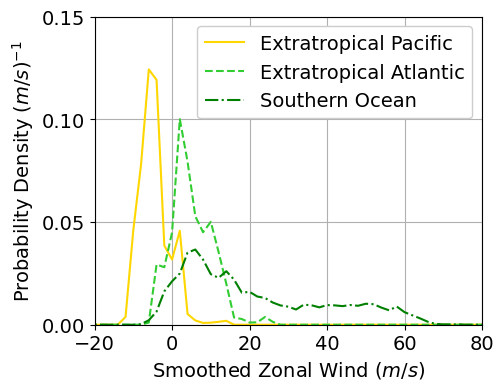

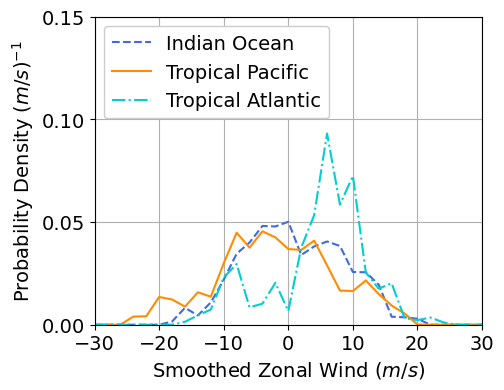

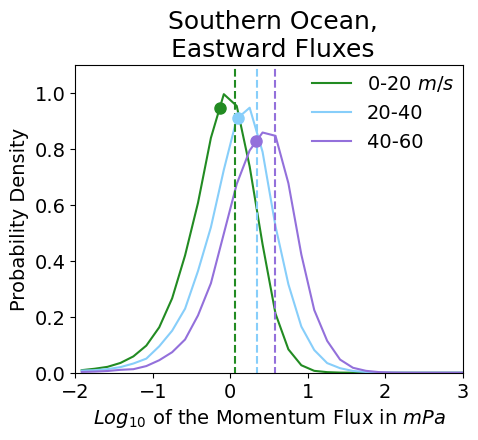

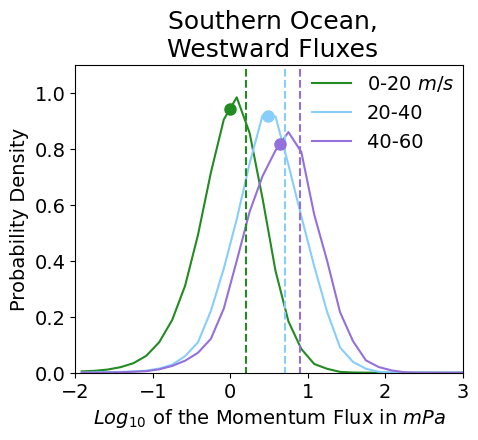

In [12]:
# The dependence of the momentum flux on the wind speed.
# These calculations support Figures 6 and 7, and the results in Table 2

wind_min = -31
wind_max = 81
wind_res = 2
bins_wind = wind_min + wind_res*np.arange(1 + (wind_max - wind_min)/wind_res)
hist_indian, bin_edges = np.histogram(indian_flights.u_smooth, bins = bins_wind)
hist_trop_pac, bin_edges = np.histogram(trop_pac_flights.u_smooth, bins = bins_wind)
hist_trop_atl, bin_edges = np.histogram(trop_atl_flights.u_smooth, bins = bins_wind)
hist_extra_pac, bin_edges = np.histogram(extra_pac_flights.u_smooth, bins = bins_wind)
hist_extra_atl, _ = np.histogram(extra_atl_flights.u_smooth, bins = bins_wind)
hist_SO, _ = np.histogram(SO_flights.u_smooth, bins = bins_wind)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

pdf_indian = hist_indian/(wind_res*np.sum(hist_indian))
pdf_trop_pac = hist_trop_pac/(wind_res*np.sum(hist_trop_pac))
pdf_trop_atl = hist_trop_atl/(wind_res*np.sum(hist_trop_atl))
pdf_extra_pac = hist_extra_pac/(wind_res*np.sum(hist_extra_pac))
pdf_extra_atl = hist_extra_atl/(wind_res*np.sum(hist_extra_atl))
pdf_SO = hist_SO/(wind_res*np.sum(hist_SO))

plt.figure(figsize=(5,4))
plt.plot(bin_centers,pdf_extra_pac,matplotlib.colors.CSS4_COLORS['gold'], linestyle='solid')
plt.plot(bin_centers,pdf_extra_atl,matplotlib.colors.CSS4_COLORS['limegreen'], linestyle='dashed')
plt.plot(bin_centers,pdf_SO,matplotlib.colors.CSS4_COLORS['green'], linestyle='dashdot')
plt.grid()
plt.xlim(-20,80)
plt.ylim(0,0.15)
plt.xticks(fontsize=14)
plt.yticks([0,0.05,0.1,0.15],fontsize=14)
plt.xlabel('Smoothed Zonal Wind $(m/s)$', fontsize=14)
plt.ylabel('Probability Density $(m/s)^{-1}$', fontsize=14)
plt.legend(['Extratropical Pacific','Extratropical Atlantic','Southern Ocean'],
           loc='upper right',fancybox=True, framealpha=1, fontsize=14);
#plt.savefig('temp1.pdf', format='pdf', bbox_inches='tight');

plt.figure(figsize=(5,4))
plt.plot(bin_centers,pdf_indian,matplotlib.colors.CSS4_COLORS['royalblue'], linestyle='dashed')
plt.plot(bin_centers,pdf_trop_pac,matplotlib.colors.CSS4_COLORS['darkorange'], linestyle='solid')
plt.plot(bin_centers,pdf_trop_atl,matplotlib.colors.CSS4_COLORS['darkturquoise'], linestyle='dashdot')
plt.grid()
plt.xlim(-30,30)
plt.ylim(0,0.15)
plt.xticks(fontsize=14)
plt.yticks([0,0.05,0.1,0.15],fontsize=14)
plt.xlabel('Smoothed Zonal Wind $(m/s)$', fontsize=14)
plt.ylabel('Probability Density $(m/s)^{-1}$', fontsize=14)
plt.legend(['Indian Ocean','Tropical Pacific','Tropical Atlantic'],
           loc='upper left',fancybox=True, framealpha=1, fontsize=14);
#plt.savefig('temp2.pdf', format='pdf', bbox_inches='tight');



# Southern Ocean
bins_log10_flux = -2 + np.arange(36)*(5/30)
bins_res = bins_log10_flux[1] - bins_log10_flux[0]

temp_flights = SO_flights.copy()
temp_flights['flux_u_w'] = temp_flights.flux_east + temp_flights.flux_west
n_vals = temp_flights.shape[0]
temp_flights_windband1 = temp_flights[(temp_flights.u_smooth >= 0) & (temp_flights.u_smooth < 20)]
temp_flights_windband2 = temp_flights[(temp_flights.u_smooth >= 20) & (temp_flights.u_smooth < 40)]
temp_flights_windband3 = temp_flights[(temp_flights.u_smooth >= 40) & (temp_flights.u_smooth < 60)]
print('Southern Ocean:')
print('0-20 m/s')
print('Mean total zonal momentum flux:', 1000*np.nanmean(temp_flights_windband1.flux_u_w))
print('Mean eastward momentum flux:   ', 1000*np.nanmean(temp_flights_windband1.flux_east))
print('Mean westward momentum flux:   ', -1000*np.nanmean(temp_flights_windband1.flux_west))
print('Ratio of eastward to westward: ',
      -np.nanmean(temp_flights_windband1.flux_east)/np.nanmean(temp_flights_windband1.flux_west))
temp = np.log10(1000*temp_flights_windband1.flux_east)
temp = temp[np.isfinite(temp) == 1]
print('Mean Log10 eastward momentum flux:', np.mean(temp))
print('Sigma Log10 eastward momentum flux:', np.std(temp))
temp = np.log10(-1000*temp_flights_windband1.flux_west)
temp = temp[np.isfinite(temp) == 1]
print('Mean Log10 westward momentum flux:', np.mean(temp))
print('Sigma Log10 westward momentum flux:', np.std(temp))
print('')
print('20-40 m/s')
print('Mean total zonal momentum flux:', 1000*np.nanmean(temp_flights_windband2.flux_u_w))
print('Mean eastward momentum flux:   ', 1000*np.nanmean(temp_flights_windband2.flux_east))
print('Mean westward momentum flux:   ', -1000*np.nanmean(temp_flights_windband2.flux_west))
print('Ratio of eastward to westward: ',
      -np.nanmean(temp_flights_windband2.flux_east)/np.nanmean(temp_flights_windband2.flux_west))
temp = np.log10(1000*temp_flights_windband2.flux_east)
temp = temp[np.isfinite(temp) == 1]
print('Mean Log10 eastward momentum flux:', np.mean(temp))
print('Sigma Log10 eastward momentum flux:', np.std(temp))
temp = np.log10(-1000*temp_flights_windband2.flux_west)
temp = temp[np.isfinite(temp) == 1]
print('Mean Log10 westward momentum flux:', np.mean(temp))
print('Sigma Log10 westward momentum flux:', np.std(temp))
print('')
print('40-60 m/s')
print('Mean total zonal momentum flux:', 1000*np.nanmean(temp_flights_windband3.flux_u_w))
print('Mean eastward momentum flux:   ', 1000*np.nanmean(temp_flights_windband3.flux_east))
print('Mean westward momentum flux:   ', -1000*np.nanmean(temp_flights_windband3.flux_west))
print('Ratio of eastward to westward: ',
      -np.nanmean(temp_flights_windband3.flux_east)/np.nanmean(temp_flights_windband3.flux_west))
temp = np.log10(1000*temp_flights_windband3.flux_east)
temp = temp[np.isfinite(temp) == 1]
print('Mean Log10 eastward momentum flux:', np.mean(temp))
print('Sigma Log10 eastward momentum flux:', np.std(temp))
temp = np.log10(-1000*temp_flights_windband3.flux_west)
temp = temp[np.isfinite(temp) == 1]
print('Mean Log10 westward momentum flux:', np.mean(temp))
print('Sigma Log10 westward momentum flux:', np.std(temp))
print('')
print('')

temp1 = np.array(np.log10(1000*temp_flights_windband1.flux_east.copy()))
temp2 = np.array(np.log10(-1000*temp_flights_windband1.flux_west.copy()))
temp3 = np.array(np.log10(1000*temp_flights_windband2.flux_east.copy()))
temp4 = np.array(np.log10(-1000*temp_flights_windband2.flux_west.copy()))
temp5 = np.array(np.log10(1000*temp_flights_windband3.flux_east.copy()))
temp6 = np.array(np.log10(-1000*temp_flights_windband3.flux_west.copy()))
hist1, bin_edges = np.histogram(temp1, bins = bins_log10_flux)
hist2, _         = np.histogram(temp2, bins = bins_log10_flux)
hist3, _         = np.histogram(temp3, bins = bins_log10_flux)
hist4, _         = np.histogram(temp4, bins = bins_log10_flux)
hist5, _         = np.histogram(temp5, bins = bins_log10_flux)
hist6, _         = np.histogram(temp6, bins = bins_log10_flux)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_center_flux = 10**bin_centers

plt.figure(figsize=(5,4))
plt.plot(bin_centers,hist1/(hist1.sum()*bins_res), color = matplotlib.colors.CSS4_COLORS['forestgreen'])
plt.plot(bin_centers,hist3/(hist3.sum()*bins_res), color = matplotlib.colors.CSS4_COLORS['lightskyblue'])
plt.plot(bin_centers,hist5/(hist5.sum()*bins_res), color = matplotlib.colors.CSS4_COLORS['mediumpurple'])
plt.plot([np.log10(1000*temp_flights_windband1.flux_east.mean()),
          np.log10(1000*temp_flights_windband1.flux_east.mean())],
         [-1,2],matplotlib.colors.CSS4_COLORS['forestgreen'],linestyle='dashed')
plt.plot([np.log10(1000*temp_flights_windband2.flux_east.mean()),
          np.log10(1000*temp_flights_windband2.flux_east.mean())],
         [-1,2],matplotlib.colors.CSS4_COLORS['lightskyblue'],linestyle='dashed')
plt.plot([np.log10(1000*temp_flights_windband3.flux_east.mean()),
          np.log10(1000*temp_flights_windband3.flux_east.mean())],
         [-1,2],matplotlib.colors.CSS4_COLORS['mediumpurple'],linestyle='dashed')
temp = temp1[np.isfinite(temp1) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist1/(hist1.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['forestgreen'],markersize=8)
temp = temp3[np.isfinite(temp3) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist3/(hist3.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['lightskyblue'],markersize=8)
temp = temp5[np.isfinite(temp5) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist5/(hist5.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumpurple'],markersize=8)
plt.xlim(-2,3)
plt.ylim(0,1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('  Southern Ocean, \n Eastward Fluxes', fontsize=18)
plt.xlabel('$Log_{10}$ of the Momentum Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['0-20 $m/s$',
            '20-40',
            '40-60'],
           bbox_to_anchor=(0.567, 1.027), loc='upper left',
           framealpha=0, fontsize=14);
#plt.savefig('temp7.pdf', format='pdf', bbox_inches='tight');

plt.figure(figsize=(5,4))
plt.plot(bin_centers,hist2/(hist2.sum()*bins_res), color = matplotlib.colors.CSS4_COLORS['forestgreen'])
plt.plot(bin_centers,hist4/(hist4.sum()*bins_res), color = matplotlib.colors.CSS4_COLORS['lightskyblue'])
plt.plot(bin_centers,hist6/(hist6.sum()*bins_res), color = matplotlib.colors.CSS4_COLORS['mediumpurple'])
plt.plot([np.log10(-1000*temp_flights_windband1.flux_west.mean()),
          np.log10(-1000*temp_flights_windband1.flux_west.mean())],
         [-1,2],matplotlib.colors.CSS4_COLORS['forestgreen'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights_windband2.flux_west.mean()),
          np.log10(-1000*temp_flights_windband2.flux_west.mean())],
         [-1,2],matplotlib.colors.CSS4_COLORS['lightskyblue'],linestyle='dashed')
plt.plot([np.log10(-1000*temp_flights_windband3.flux_west.mean()),
          np.log10(-1000*temp_flights_windband3.flux_west.mean())],
         [-1,2],matplotlib.colors.CSS4_COLORS['mediumpurple'],linestyle='dashed')
temp = temp2[np.isfinite(temp2) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist2/(hist2.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['forestgreen'],markersize=8)
temp = temp4[np.isfinite(temp4) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist4/(hist4.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['lightskyblue'],markersize=8)
temp = temp6[np.isfinite(temp6) == 1]
temp = np.mean(temp)
plt.plot(temp,np.interp(temp,bin_centers,hist6/(hist6.sum()*(bins_log10_flux[1]-bins_log10_flux[0]))),
         'o',c=matplotlib.colors.CSS4_COLORS['mediumpurple'],markersize=8)
plt.xlim(-2,3)
plt.ylim(0,1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('  Southern Ocean, \n Westward Fluxes', fontsize=18)
plt.xlabel('$Log_{10}$ of the Momentum Flux in $mPa$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(['0-20 $m/s$',
            '20-40',
            '40-60'],
           bbox_to_anchor=(0.567, 1.027), loc='upper left',
           framealpha=0, fontsize=14);
#plt.savefig('temp8.pdf', format='pdf', bbox_inches='tight');




print('Extratropical Pacific:')
temp_flights = extra_pac_flights.copy()
temp_flights['flux_u_w'] = temp_flights.flux_east + temp_flights.flux_west
n_vals = temp_flights.shape[0]
temp_flights_windband1 = temp_flights[(temp_flights.u_smooth >= -5) & (temp_flights.u_smooth < 5)]
temp_flights_windband2 = temp_flights[(temp_flights.u_smooth >= -15) & (temp_flights.u_smooth < -5)]
print('Mean total zonal momentum flux in wind band 1:', 1000*np.nanmean(temp_flights_windband1.flux_u_w))
print('Mean eastward momentum flux in wind band 1:   ', 1000*np.nanmean(temp_flights_windband1.flux_east))
print('Mean westward momentum flux in wind band 1:   ', -1000*np.nanmean(temp_flights_windband1.flux_west))
print('Mean total zonal momentum flux in wind band 2:', 1000*np.nanmean(temp_flights_windband2.flux_u_w))
print('Mean eastward momentum flux in wind band 2:   ', 1000*np.nanmean(temp_flights_windband2.flux_east))
print('Mean westward momentum flux in wind band 2:   ', -1000*np.nanmean(temp_flights_windband2.flux_west))
print('')
print('')
print('Extratropical Atlantic:')
temp_flights = extra_atl_flights.copy()
temp_flights['flux_u_w'] = temp_flights.flux_east + temp_flights.flux_west
n_vals = temp_flights.shape[0]
temp_flights_windband1 = temp_flights[(temp_flights.u_smooth >= -5) & (temp_flights.u_smooth < 5)]
temp_flights_windband2 = temp_flights[(temp_flights.u_smooth >= 5) & (temp_flights.u_smooth < 15)]
print('Mean total zonal momentum flux in wind band 1:', 1000*np.nanmean(temp_flights_windband1.flux_u_w))
print('Mean eastward momentum flux in wind band 1:   ', 1000*np.nanmean(temp_flights_windband1.flux_east))
print('Mean westward momentum flux in wind band 1:   ', -1000*np.nanmean(temp_flights_windband1.flux_west))
print('Mean total zonal momentum flux in wind band 2:', 1000*np.nanmean(temp_flights_windband2.flux_u_w))
print('Mean eastward momentum flux in wind band 2:   ', 1000*np.nanmean(temp_flights_windband2.flux_east))
print('Mean westward momentum flux in wind band 2:   ', -1000*np.nanmean(temp_flights_windband2.flux_west))
print('')
print('')
print('Indian Ocean:')
temp_flights = indian_flights.copy()
temp_flights['flux_u_w'] = temp_flights.flux_east + temp_flights.flux_west
n_vals = temp_flights.shape[0]
temp_flights_windband1 = temp_flights[temp_flights.u_smooth > 0]
temp_flights_windband2 = temp_flights[temp_flights.u_smooth < 0]
print('Mean total zonal momentum flux in wind band 1:', 1000*np.nanmean(temp_flights_windband1.flux_u_w))
print('Mean eastward momentum flux in wind band 1:   ', 1000*np.nanmean(temp_flights_windband1.flux_east))
print('Mean westward momentum flux in wind band 1:   ', -1000*np.nanmean(temp_flights_windband1.flux_west))
print('Mean total zonal momentum flux in wind band 2:', 1000*np.nanmean(temp_flights_windband2.flux_u_w))
print('Mean eastward momentum flux in wind band 2:   ', 1000*np.nanmean(temp_flights_windband2.flux_east))
print('Mean westward momentum flux in wind band 2:   ', -1000*np.nanmean(temp_flights_windband2.flux_west))
print('')
print('')
print('Tropical Pacific:')
temp_flights = trop_pac_flights.copy()
temp_flights['flux_u_w'] = temp_flights.flux_east + temp_flights.flux_west
n_vals = temp_flights.shape[0]
temp_flights_windband1 = temp_flights[temp_flights.u_smooth > 0]
temp_flights_windband2 = temp_flights[temp_flights.u_smooth < 0]
print('Mean total zonal momentum flux in wind band 1:', 1000*np.nanmean(temp_flights_windband1.flux_u_w))
print('Mean eastward momentum flux in wind band 1:   ', 1000*np.nanmean(temp_flights_windband1.flux_east))
print('Mean westward momentum flux in wind band 1:   ', -1000*np.nanmean(temp_flights_windband1.flux_west))
print('Mean total zonal momentum flux in wind band 2:', 1000*np.nanmean(temp_flights_windband2.flux_u_w))
print('Mean eastward momentum flux in wind band 2:   ', 1000*np.nanmean(temp_flights_windband2.flux_east))
print('Mean westward momentum flux in wind band 2:   ', -1000*np.nanmean(temp_flights_windband2.flux_west))
print('')
print('')
print('Tropical Atlantic:')
temp_flights = trop_atl_flights.copy()
temp_flights['flux_u_w'] = temp_flights.flux_east + temp_flights.flux_west
n_vals = temp_flights.shape[0]
temp_flights_windband1 = temp_flights[temp_flights.u_smooth > 0]
temp_flights_windband2 = temp_flights[temp_flights.u_smooth < 0]
print('Mean total zonal momentum flux in wind band 1:', 1000*np.nanmean(temp_flights_windband1.flux_u_w))
print('Mean eastward momentum flux in wind band 1:   ', 1000*np.nanmean(temp_flights_windband1.flux_east))
print('Mean westward momentum flux in wind band 1:   ', -1000*np.nanmean(temp_flights_windband1.flux_west))
print('Mean total zonal momentum flux in wind band 2:', 1000*np.nanmean(temp_flights_windband2.flux_u_w))
print('Mean eastward momentum flux in wind band 2:   ', 1000*np.nanmean(temp_flights_windband2.flux_east))
print('Mean westward momentum flux in wind band 2:   ', -1000*np.nanmean(temp_flights_windband2.flux_west))
print('')
print('')

In [16]:
# Calculations supporting the discussion in section 5 on the dependence of the momentum flux
# on the wind speed over the Southern Ocean

int_pct1 = 0.5
int_pct2 = 0.99

# Southern Ocean, eastward fluxes, windband2 - windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband2.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = temp_flights_windband1.copy()
fluxW = np.array(1000*temp_flights.flux_east)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband2 Eastward Fluxes, W: SO Windband1 Eastward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, eastward fluxes, windband3 - windband2
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband3.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = temp_flights_windband2.copy()
fluxW = np.array(1000*temp_flights.flux_east)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband3 Eastward Fluxes, W: SO Windband2 Eastward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, eastward fluxes, windband2 - windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband3.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = temp_flights_windband1.copy()
fluxW = np.array(1000*temp_flights.flux_east)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband3 Eastward Fluxes, W: SO Windband1 Eastward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, westward fluxes, windband2 - windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband2.copy()
fluxE = np.array(-1000*temp_flights.flux_west)
temp_flights = temp_flights_windband1.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband2 Westward Fluxes, W: SO Windband1 Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, westward fluxes, windband2 - windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband3.copy()
fluxE = np.array(-1000*temp_flights.flux_west)
temp_flights = temp_flights_windband2.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband3 Westward Fluxes, W: SO Windband2 Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, westward fluxes, windband2 - windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband3.copy()
fluxE = np.array(-1000*temp_flights.flux_west)
temp_flights = temp_flights_windband1.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband3 Westward Fluxes, W: SO Windband1 Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, eastward - westward fluxes, windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband1.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = temp_flights_windband1.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband1 Eastward Fluxes, W: SO Windband1 Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, eastward - westward fluxes, windband2
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband2.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = temp_flights_windband2.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband2 Eastward Fluxes, W: SO Windband2 Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')







# Southern Ocean, eastward - westward fluxes, windband1
# I'm keeping the E/W variable names to avoid confusion and to avoid rewriting a bunch of stuff
temp_flights = temp_flights_windband3.copy()
fluxE = np.array(1000*temp_flights.flux_east)
temp_flights = temp_flights_windband3.copy()
fluxW = np.array(-1000*temp_flights.flux_west)
log10E = np.log10(fluxE)
log10W = np.log10(fluxW)
log10E = log10E[np.isfinite(log10E) == 1]
log10W = log10W[np.isfinite(log10W) == 1]

mean_log10E = np.mean(log10E)
mean_log10W = np.mean(log10W)
std_log10E = np.std(log10E)
std_log10W = np.std(log10W)

# Match the means and standard deviations of the eastward and westward distributions
log10E_shifted = log10E + (mean_log10W - mean_log10E)
log10W_shifted = log10W + (mean_log10E - mean_log10W)
log10E_squeezed = mean_log10E + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_squeezed = mean_log10W + (log10W - mean_log10W)*(std_log10E/std_log10W)
log10E_shifted_squeezed = mean_log10W + (log10E - mean_log10E)*(std_log10W/std_log10E)
log10W_shifted_squeezed = mean_log10E + (log10W - mean_log10W)*(std_log10E/std_log10W)

fluxE_shifted = 10**log10E_shifted
fluxE_squeezed = 10**log10E_squeezed
fluxE_shifted_squeezed = 10**log10E_shifted_squeezed
fluxW_shifted = 10**log10W_shifted
fluxW_squeezed = 10**log10W_squeezed
fluxW_shifted_squeezed = 10**log10W_shifted_squeezed

temp = np.sort(fluxE)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E = np.interp(int_pct1,percentiles,temp)
flux_pct2E = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W = np.interp(int_pct1,percentiles,temp)
flux_pct2W = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxE_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1E_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2E_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

temp = np.sort(fluxW_shifted_squeezed)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1W_shifted_squeezed = np.interp(int_pct1,percentiles,temp)
flux_pct2W_shifted_squeezed = np.interp(int_pct2,percentiles,temp)

print('E: SO Windband3 Eastward Fluxes, W: SO Windband3 Westward Fluxes')
print('Eastward, Westward Mean Flux (mPa):', np.mean(fluxE), np.mean(fluxW))
print('Shifted E, Shifted W (mPa):        ', np.mean(fluxE_shifted), np.mean(fluxW_shifted))
print('Squeezed E, Squeezed W (mPa):      ', np.mean(fluxE_squeezed), np.mean(fluxW_squeezed))
print('Sh+Sq E, Sh_Sq W (mPa):            ', np.mean(fluxE_shifted_squeezed), np.mean(fluxW_shifted_squeezed))
print('Difference, E-W (mPa):             ', np.mean(fluxE) - np.mean(fluxW))
print('for E - shE, shW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_shifted), 
      np.mean(fluxW_shifted) - np.mean(fluxW))
print('for E - sqE, sqW - W (mPa):        ',
      np.mean(fluxE) - np.mean(fluxE_squeezed), 
      np.mean(fluxW_squeezed) - np.mean(fluxW))
print('for E - sh+sqE, sh+sqW - W (mPa):  ',
      np.mean(fluxE) - np.mean(fluxE_shifted_squeezed), 
      np.mean(fluxW_shifted_squeezed) - np.mean(fluxW))
print('% explained by E - shE, shW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted)) + (np.mean(fluxW_shifted) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sqE, sqW - W:       ',
      100*((np.mean(fluxE) - np.mean(fluxE_squeezed)) + (np.mean(fluxW_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('% explained by E - sh+sqE, sh+sqW - W :',
      100*((np.mean(fluxE) - np.mean(fluxE_shifted_squeezed)) + (np.mean(fluxW_shifted_squeezed) - np.mean(fluxW)))/
      (2*(np.mean(fluxE) - np.mean(fluxW))))
print('')
print('')

E: SO Windband2 Eastward Fluxes, W: SO Windband1 Eastward Fluxes
Eastward, Westward Mean Flux (mPa): 0.9717780832474734 1.4679013280947766
Shifted E, Shifted W (mPa):         1.2794090461002448 1.1174459529757597
Squeezed E, Squeezed W (mPa):       1.156250491885143 1.2545185815109952
Sh+Sq E, Sh_Sq W (mPa):             1.5203539290725876 0.9540789806988987
Difference, E-W (mPa):              -0.4961232448473032
for E - shE, shW - W (mPa):         -0.30763096285277136 -0.3504553751190169
for E - sqE, sqW - W (mPa):         -0.18447240863766967 -0.21338274658378142
for E - sh+sqE, sh+sqW - W (mPa):   -0.5485758458251142 -0.5138223473958778
% explained by E - shE, shW - W:        66.32286884424596
% explained by E - sqE, sqW - W:        40.09640339910933
% explained by E - sh+sqE, sh+sqW - W : 107.06998757415377


E: SO Windband3 Eastward Fluxes, W: SO Windband2 Eastward Fluxes
Eastward, Westward Mean Flux (mPa): 3.806067533718982 0.9717780832474734
Shifted E, Shifted W (mPa):         1.

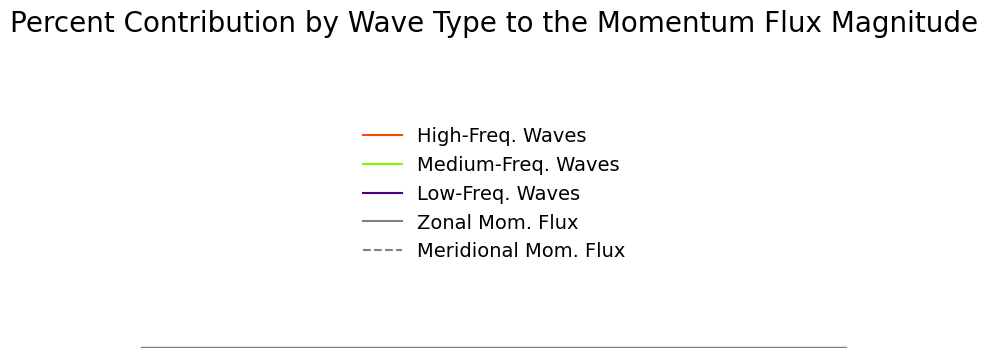

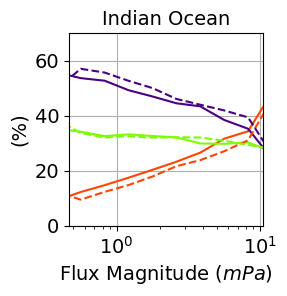

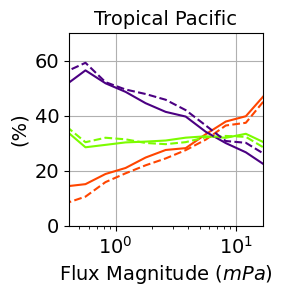

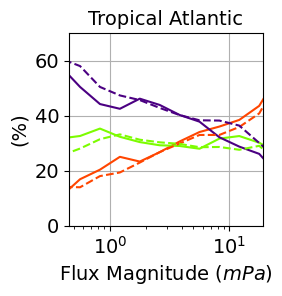

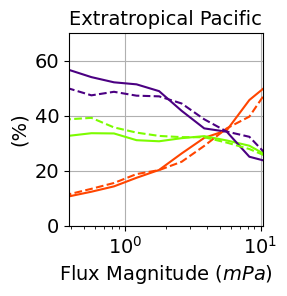

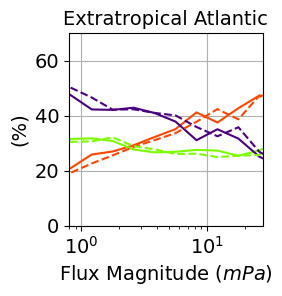

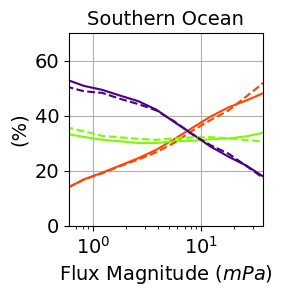

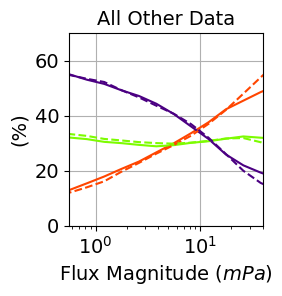

In [7]:
# Panels for paper Figure 8

int_pct1 = 0.01
int_pct2 = 0.99
min_flux = 0.5
max_flux = 30
bins_flux = np.arange(500)
bins_log10_flux = -2 + np.arange(31)*(5/30)
bins_frac = 2.5*np.arange(41)
bin_flux = 0.5*(bins_flux[1:] + bins_flux[:-1])
bin_log10_flux = 0.5*(bins_log10_flux[1:] + bins_log10_flux[:-1])
bin_log10_flux_dim = 10**bin_log10_flux
bin_frac = 0.5*(bins_frac[1:] + bins_frac[:-1])
nbins_flux = bin_flux.size
nbins_log10_flux = bin_log10_flux.size
nbins_frac = bin_frac.size

# Plot title and legend
plt.figure(figsize=(10,4))
plt.plot([0,1],[0,0],matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot([0,1],[0,0],matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot([0,1],[0,0],matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot([0,1],[0,0],color=[0.5,0.5,0.5])
plt.plot([0,1],[0,0],color=[0.5,0.5,0.5],linestyle='dashed')
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.title('Percent Contribution by Wave Type to the Momentum Flux Magnitude', fontsize=20)
plt.legend(['High-Freq. Waves','Medium-Freq. Waves','Low-Freq. Waves',
            'Zonal Mom. Flux','Meridional Mom. Flux'],
            fontsize=14,framealpha=1,frameon=False,loc='center');
#plt.savefig('temp1.pdf', format='pdf', bbox_inches='tight');







# Indian Ocean
temp_flights = indian_flights.copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Indian Ocean', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp2.pdf', format='pdf', bbox_inches='tight');







# Tropical Pacific
temp_flights = trop_pac_flights.copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Tropical Pacific', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp3.pdf', format='pdf', bbox_inches='tight');







# Tropical Atlantic
temp_flights = trop_atl_flights.copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Tropical Atlantic', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp4.pdf', format='pdf', bbox_inches='tight');







# Extratropical Pacific
temp_flights = extra_pac_flights.copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Extratropical Pacific', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp5.pdf', format='pdf', bbox_inches='tight');







# Extratropical Atlantic
temp_flights = extra_atl_flights.copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Extratropical Atlantic', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp6.pdf', format='pdf', bbox_inches='tight');







# Southern Ocean
temp_flights = SO_flights.copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Southern Ocean', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp7.pdf', format='pdf', bbox_inches='tight');







# All Other Data
temp_flights = flights[flights.grid_cell_number.isin(grid_cell_numbers[masks == 0])].copy()
temp_flights['flux_zonal_abs'] = temp_flights.flux_east - temp_flights.flux_west
temp_flights['flux_zonal_abs_HF'] = temp_flights.flux_east_HF - temp_flights.flux_west_HF
temp_flights['flux_zonal_abs_MF'] = temp_flights.flux_east_MF - temp_flights.flux_west_MF
temp_flights['flux_zonal_abs_LF'] = temp_flights.flux_east_LF - temp_flights.flux_west_LF
temp_flights['flux_zonal_abs_HF_frac'] = 100*temp_flights.flux_zonal_abs_HF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_MF_frac'] = 100*temp_flights.flux_zonal_abs_MF/temp_flights.flux_zonal_abs
temp_flights['flux_zonal_abs_LF_frac'] = 100*temp_flights.flux_zonal_abs_LF/temp_flights.flux_zonal_abs
temp_flights['flux_meridional_abs'] = temp_flights.flux_north - temp_flights.flux_south
temp_flights['flux_meridional_abs_HF'] = temp_flights.flux_north_HF - temp_flights.flux_south_HF
temp_flights['flux_meridional_abs_MF'] = temp_flights.flux_north_MF - temp_flights.flux_south_MF
temp_flights['flux_meridional_abs_LF'] = temp_flights.flux_north_LF - temp_flights.flux_south_LF
temp_flights['flux_meridional_abs_HF_frac'] = 100*temp_flights.flux_meridional_abs_HF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_MF_frac'] = 100*temp_flights.flux_meridional_abs_MF/temp_flights.flux_meridional_abs
temp_flights['flux_meridional_abs_LF_frac'] = 100*temp_flights.flux_meridional_abs_LF/temp_flights.flux_meridional_abs

hist_flux_HF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_zonal = np.histogramdd((np.log10(1000*temp_flights.flux_zonal_abs),temp_flights.flux_zonal_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_HF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_HF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_MF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_MF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]
hist_flux_LF_frac_merid = np.histogramdd((np.log10(1000*temp_flights.flux_meridional_abs),temp_flights.flux_meridional_abs_LF_frac),
                                          bins=(bins_log10_flux,bins_frac))[0]

frac_HF_zonal = hist_flux_HF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_zonal = hist_flux_MF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_zonal = hist_flux_LF_frac_zonal*np.tile(bin_frac,(nbins_log10_flux,1))
frac_HF_merid = hist_flux_HF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_MF_merid = hist_flux_MF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))
frac_LF_merid = hist_flux_LF_frac_merid*np.tile(bin_frac,(nbins_log10_flux,1))

frac_HF_zonal = np.sum(frac_HF_zonal,axis=1)/np.sum(hist_flux_HF_frac_zonal,axis=1)
frac_MF_zonal = np.sum(frac_MF_zonal,axis=1)/np.sum(hist_flux_MF_frac_zonal,axis=1)
frac_LF_zonal = np.sum(frac_LF_zonal,axis=1)/np.sum(hist_flux_LF_frac_zonal,axis=1)
frac_HF_merid = np.sum(frac_HF_merid,axis=1)/np.sum(hist_flux_HF_frac_merid,axis=1)
frac_MF_merid = np.sum(frac_MF_merid,axis=1)/np.sum(hist_flux_MF_frac_merid,axis=1)
frac_LF_merid = np.sum(frac_LF_merid,axis=1)/np.sum(hist_flux_LF_frac_merid,axis=1)

temp = np.sort(1000*temp_flights.flux_zonal_abs)
n_data = temp.size
percentiles = np.arange(n_data)/(n_data - 1)
flux_pct1 = np.interp(int_pct1,percentiles,temp)
flux_pct2 = np.interp(int_pct2,percentiles,temp)

plt.figure(figsize=(2.5,2.5))
plt.plot(bin_log10_flux_dim,frac_HF_zonal,matplotlib.colors.CSS4_COLORS['orangered'])
plt.plot(bin_log10_flux_dim,frac_MF_zonal,matplotlib.colors.CSS4_COLORS['lawngreen'])
plt.plot(bin_log10_flux_dim,frac_LF_zonal,matplotlib.colors.CSS4_COLORS['indigo'])
plt.plot(bin_log10_flux_dim,frac_HF_merid,matplotlib.colors.CSS4_COLORS['orangered'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_MF_merid,matplotlib.colors.CSS4_COLORS['lawngreen'],linestyle='dashed')
plt.plot(bin_log10_flux_dim,frac_LF_merid,matplotlib.colors.CSS4_COLORS['indigo'],linestyle='dashed')
plt.grid()
#plt.xlim(min_flux,max_flux)
plt.xlim(flux_pct1,flux_pct2)
plt.ylim(0,70)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('All Other Data', fontsize=14)
plt.xlabel('Flux Magnitude $(mPa)$', fontsize=14)
plt.ylabel('(%)', fontsize=14);
#plt.savefig('temp8.pdf', format='pdf', bbox_inches='tight');